Techniques applied  
Generalization – Replaces specific values with more general categories.  
Suppression – Masks sensitive attributes partially or fully.  
K-anonymity – Ensures each record is indistinguishable from at least 𝑘
k others.  
Differential Privacy (Laplace Mechanism) – Adds noise to numerical values.

Metrics  
Utility metrics - information loss, data distortion, and privacy protection strength.  
Data Distortion Rate – Percentage of modified values.  
Entropy Reduction – Measures loss of information.  
Adversarial Risk Score – How easy it is to re-identify users (lower is better).  

In [3]:
!pip install diffprivlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 3.5 MB/s eta 0:00:00


{'Differential Privacy': {'Adversarial Risk Score': 0.1111111111111111,
                          'Data Distortion Rate': 0.3333333333333333,
                          'Distinct ZIP Codes': 8,
                          'Entropy Reduction': -0.00023989946223296573,
                          'Mean Absolute Error (Age)': 0.0,
                          'Mean Absolute Error (Salary)': 7212.458781279291},
 'Generalization': {'Adversarial Risk Score': 0.1111111111111111,
                    'Data Distortion Rate': 0.3333333333333333,
                    'Distinct ZIP Codes': 8,
                    'Entropy Reduction': 0.0,
                    'Mean Absolute Error (Age)': 1.0,
                    'Mean Absolute Error (Salary)': 0.0},
 'K-Anonymity': {'Adversarial Risk Score': 1.0,
                 'Data Distortion Rate': 1.0,
                 'Distinct ZIP Codes': 0,
                 'Entropy Reduction': nan,
                 'Mean Absolute Error (Age)': 1.0,
                 'Mean Absolute Er

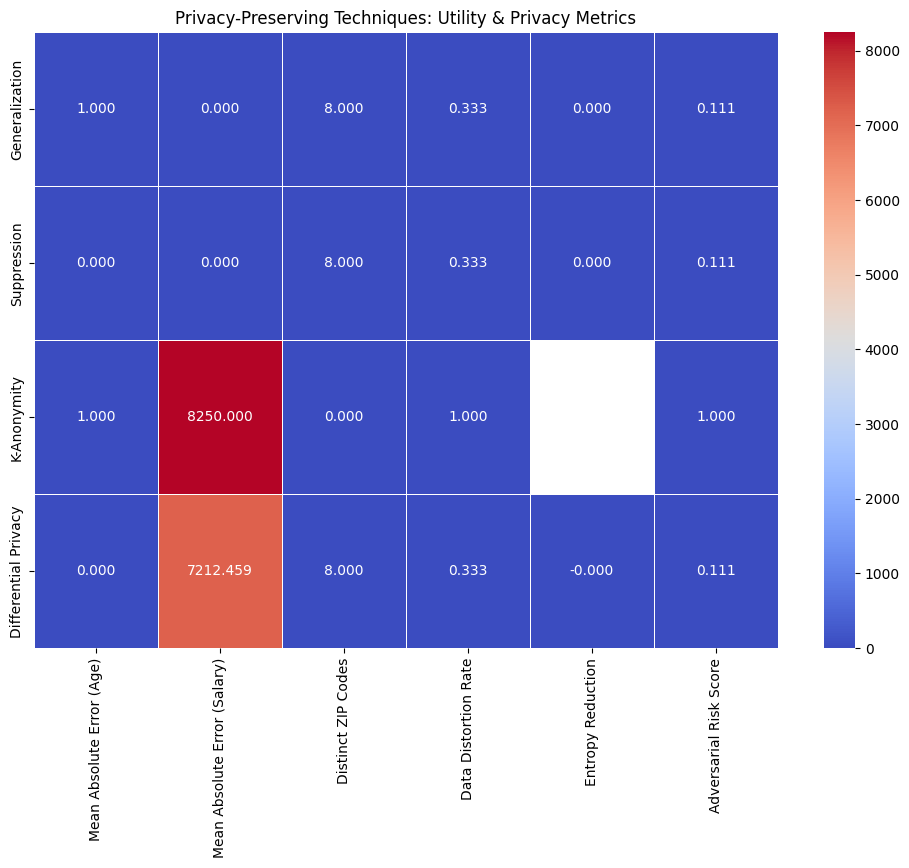

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from diffprivlib.mechanisms import Laplace

# Sample dataset with sensitive information
data = pd.DataFrame({
    'Age': [25, 34, 45, 52, 29, 40, 33, 50],
    'ZIP': ['12345', '23456', '34567', '45678', '56789', '67890', '78901', '89012'],
    'Salary': [50000, 60000, 70000, 80000, 55000, 65000, 62000, 78000]
})

# 1. Generalization (Bucketizing Age)
def generalize_age(df):
    bins = [20, 30, 40, 50, 60]
    labels = ['20-30', '30-40', '40-50', '50-60']
    df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)
    return df

generalized_data = generalize_age(data.copy())

# 2. Suppression (Masking ZIP partially)
def suppress_zip(df):
    df['ZIP'] = df['ZIP'].str[:3] + '**'
    return df

suppressed_data = suppress_zip(data.copy())

# 3. K-Anonymity (Grouping by Age and ZIP prefix)
def k_anonymity(df, k=2):
    df['ZIP'] = df['ZIP'].str[:3] + '**'
    grouped = df.groupby(['Age', 'ZIP']).filter(lambda x: len(x) >= k)
    return grouped

k_anonymous_data = k_anonymity(data.copy())

# 4. Differential Privacy (Adding Laplace noise to Salary)
def apply_differential_privacy(df, epsilon=1.0):
    mech = Laplace(epsilon=epsilon, sensitivity=10000)
    df['Salary'] = df['Salary'].apply(lambda x: x + mech.randomise(0))
    return df

differentially_private_data = apply_differential_privacy(data.copy())

# Compute utility metrics
def compute_metrics(original, transformed):
    transformed = transformed.reindex(original.index)

    # Handle missing values
    age_error = np.mean(original['Age'].astype(str) != transformed['Age'].astype(str))
    salary_error = np.mean(np.abs(original['Salary'].fillna(original['Salary'].mean()) - transformed['Salary'].fillna(original['Salary'].mean())))
    distinct_zip = len(set(transformed['ZIP'].dropna()))

    # Data Distortion Rate
    total_values = np.prod(original.shape)
    changed_values = np.sum((original.astype(str) != transformed.astype(str)).values)
    distortion_rate = changed_values / total_values

    # Entropy Reduction (Information Loss)
    original_entropy = entropy(original['Salary'])
    transformed_entropy = entropy(transformed['Salary'])
    entropy_loss = (original_entropy - transformed_entropy) / original_entropy if original_entropy else 0

    # Adversarial Risk Score
    risk_score = 1 / (distinct_zip + 1)

    return {
        'Mean Absolute Error (Age)': age_error,
        'Mean Absolute Error (Salary)': salary_error,
        'Distinct ZIP Codes': distinct_zip,
        'Data Distortion Rate': distortion_rate,
        'Entropy Reduction': entropy_loss,
        'Adversarial Risk Score': risk_score
    }

metrics = {
    'Generalization': compute_metrics(data, generalized_data),
    'Suppression': compute_metrics(data, suppressed_data),
    'K-Anonymity': compute_metrics(data, k_anonymous_data),
    'Differential Privacy': compute_metrics(data, differentially_private_data)
}

# Display results
import pprint
pprint.pprint(metrics)

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics).T

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title('Privacy-Preserving Techniques: Utility & Privacy Metrics')
plt.show()

# # Visualization - Bar Chart
# metrics_df.plot(kind='bar', figsize=(14, 8), colormap='viridis', edgecolor='black')
# plt.title('Comparison of Privacy-Preserving Techniques')
# plt.xlabel('Privacy Technique')
# plt.ylabel('Metric Values')
# plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


## Final Thoughts
If you prioritize privacy:  
→ K-Anonymity & Differential Privacy are best (but high data distortion).

If you prioritize utility:   
→ Suppression keeps data useful while partially hiding sensitive info.  

If balance is needed:   
→ Generalization reduces precision without extreme data loss.